<a href="https://colab.research.google.com/github/aimonlabs/aimon-python-sdk/blob/reprompting-api/re_prompting_pipeline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Re-Prompting Pipeline Demo
This notebook walks through how to use AIMon's re-prompting pipeline to refine LLM outputs.

With this pipeline, you can:

*   Unlock **GPT‑4o‑level performance** using lightweight 3–7B parameter models
*   Boost **instruction adherence by ~22%**
*   Minimize hallucinations while keeping responses fast

**How it works:**

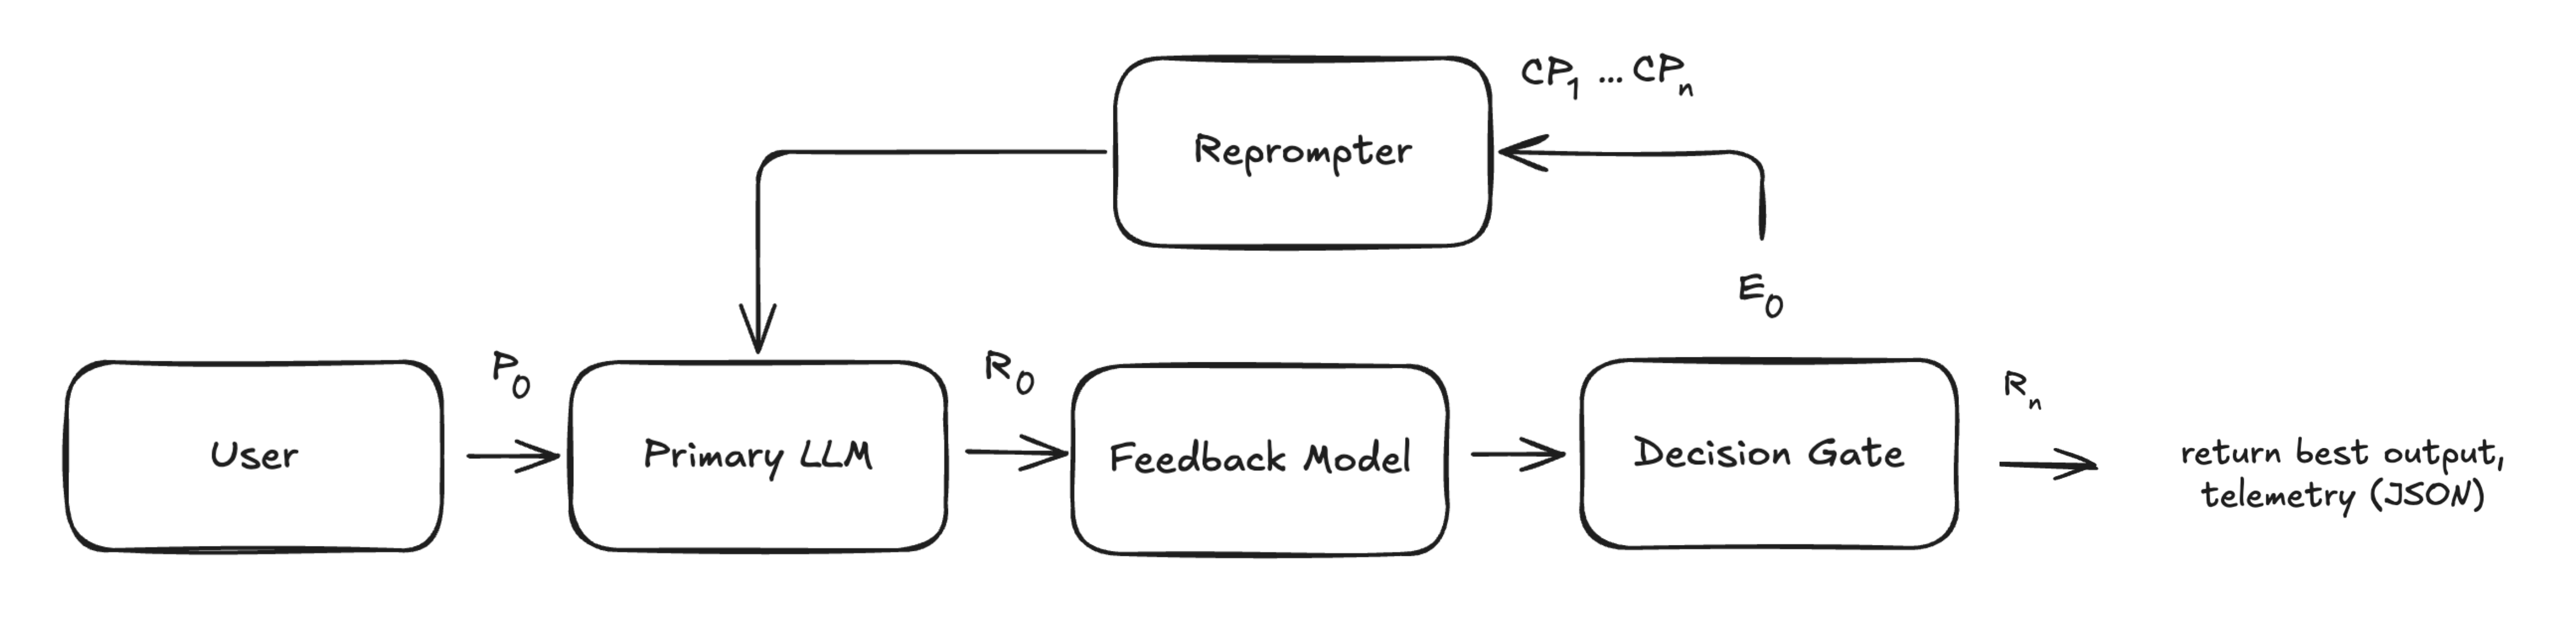

1. **Generate:** A base LLM produces an initial response.
2. **Detect:** AIMon’s IFE model evaluates the response for instruction adherence, hallucination, and toxicity.
3. **Re‑prompt:** If issues are detected, the pipeline generates a targeted corrective prompt.
4. **Refine:** The LLM revises its answer using this feedback, repeating until criteria are met or specified limits are reached.


**Goal:**  
By the end, you'll know how to integrate the re‑prompting pipeline into your own workflows and tune it for different performance/quality needs. In this demo, we will use TogetherAI to call Mistral 7B. However, the pipeline is model‑ and framework‑agnostic so it is easy to apply to any black‑box LLM and integrate with your existing retrieval stack.

### Prerequisites

1. Get your API keys

  AIMon: Instructions [available here](https://docs.aimon.ai/quickstart#1-api-key)

  TogetherAI: Get your TogetherAI API Key [available here](https://www.together.ai/)

  Once you obtained this keys, configure your `AIMON_API_KEY` and `TOGETHER_API_KEY` in Google Collab secrets and provide them notebook access. We will TogetherAI to facilitate LLM calls and AIMon to evaluate instruction adherence, groundedness, and toxicity of generated outputs to fuel iterative improvement.

2. Install the dependencies.

In [6]:
%%capture
!pip install together --quiet
%cd /content
!rm -rf aimon-python-sdk
!git clone -b reprompting-api https://github.com/aimonlabs/aimon-python-sdk.git
%cd aimon-python-sdk
!pip install -e .

3. Load the API keys into environment variables using the following cell.

In [7]:
import os

# Import Colab Secrets userdata module.
from google.colab import userdata

os.environ['TOGETHER_API_KEY'] = userdata.get('TOGETHER_API_KEY')
os.environ['AIMON_API_KEY'] = userdata.get('AIMON_API_KEY')

### Step 1: Set up your LLM function

To use the re‑prompting pipeline, you must provide your own Callable LLM function. This function acts as the connector between the pipeline and any black‑box model (e.g., TogetherAI, OpenAI, Anthropic, or a local model). In this case we are using Mistral7B via TogetherAI.

The function should take in the following parameters:

*   **`recommended_prompt_template` (string.Template):** the corrective prompt template generated by the pipeline.
*   **`system_prompt` (str):** system-level instructions or guidelines for model behavior.
*   **`context` (str):** the contextual information or reference material relevant to the query. This is typically passed from a retrieval step or knowledge base.
*   **`user_query` (str):** the user's query.

**Return value:**
Your function must return a single string containing the model's generated response.

How it works:

1. Receive the corrective prompt as a string.Template.

2. Substitute placeholders (system_prompt, context, user_query) into the template. You can alternatively implement your own template or modify the provided one for more control.

3. Send the filled prompt to your chosen model (e.g., TogetherAI, OpenAI, Anthropic, local model).

4. Return the model’s response as plain text.

> Try swapping `model` for any Together-hosted model (e.g., 'mistralai/Mistral-7B-Instruct-v0.2'). You can also replace the whole block with any LLM call (OpenAI, Claude, HuggingFace, etc.)


In [23]:
from string import Template
from together import Together

TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY")
client = Together(api_key=TOGETHER_API_KEY)

def my_llm(recommended_prompt_template: Template, system_prompt, context, user_query) -> str:

    # substitute placeholders in the pipeline-provided template with appropriate values
    filled_prompt = recommended_prompt_template.substitute(
        system_prompt=system_prompt,
        context=context,
        user_query=user_query
    )

    # replace this block with any LLM call you want. (OpenAI, Claude, HuggingFace, etc.)
    response = client.chat.completions.create(
        model="google/gemma-3n-E4B-it", # this can be any Together-hosted model (e.g., 'mistralai/Mistral-7B-Instruct-v0.2')
        messages=[{"role": "user", "content": filled_prompt}],
        max_tokens=256, # increase for longer outputs
        temperature=0 # raise for more creative outputs
    )

    # extract and return a string output
    output = response.choices[0].message.content
    return output

### Step 2: Set up AIMon's RepromptingConfig

The RepromptingConfig object controls how the pipeline behaves. Here are some of the key parameters:

* **`aimon_api_key` (str)** Your AIMon API key, used to call the Instruction‑Following Evaluation (IFE) model that scores and guides the LLM’s outputs. If not provided directly, the pipeline looks for the key in the AIMON_API_KEY environment variable.

* **`return_telemetry` (bool)** If True, the pipeline returns a detailed JSON log of every iteration. This includes each draft response, feedback, and corrective prompt. Great for debugging or analyzing model behavior. Default False.

* **`return_aimon_summary` (bool)** If True, the pipeline returns a short summary: "[2 iterations, 0 failed instruction remaining]." Default False.

* **`max_iterations` (int)** Sets how many times the pipeline will attempt to refine the model’s output. For example, 3 means “1 initial response + up to 2 corrective re‑prompts.” 2-3 recommended. Default 2.



In [24]:
from aimon.reprompting_api.config import RepromptingConfig

config = RepromptingConfig(
        aimon_api_key=os.getenv("AIMON_API_KEY"),
        return_telemetry=True,
        return_aimon_summary=True,
        max_iterations=3
    )

### Step 3: Run the re-prompting pipeline

#### 1. Define test inputs.

Before running the pipeline, you need to provide:

* **`user_query` (required):** The actual question or task for the model.

* **`system_prompt`:** A high‑level role or behavior definition for the model.

* **`context` (recommended):** Relevant background text for the model to reference (e.g., a document, policy, or knowledge base excerpt).

* **`user_instructions` (recommended):** Specific, deterministic guidelines for how the response should be written. These are what AIMon uses to evaluate and iteratively improve the model’s output.

> **Tip:** The more specific and deterministic your instructions, the more effective the re-prompting loop will be.

In [25]:
user_query = "All my loans are for graduate studies, at which date in the future are they forgiven?"
system_prompt = "You are a knowledgeable but approachable student loan advisor. Your role is to help borrowers understand complex federal repayment and forgiveness programs by breaking down policy details into clear, accurate, and accessible explanations. Always provide complete information necessary to answer the question, while maintaining a professional and neutral tone."
context = "Income-Driven Repayment (IDR) plans help lower federal student loan payments based on income and family size, with four options available: REPAYE, PAYE, IBR, and ICR. REPAYE and PAYE require payments of 10% of discretionary income, with forgiveness after 20 years for undergraduate loans and 25 years for graduate loans. IBR varies between 10% and 15% based on when loans were taken, with forgiveness after 20 or 25 years, while ICR calculates payments as the lesser of 20% of discretionary income or a fixed 12-year repayment amount, with forgiveness after 25 years. Eligibility requires a verified FSA ID, recent income documentation, and annual recertification of income and family size; failure to recertify may increase payments and interest. Joint filers must include their spouse’s income unless separated, and only Direct Loans qualify unless others are consolidated. Private loans are ineligible, and borrowers in default must make satisfactory arrangements before enrolling."
user_instructions = [
    "Avoid overly technical or robotic phrasing; keep the tone human and accessible.",
    "Keep the tone professionally neutral by avoiding emotionally charged words, exclamations, or informal phrases (e.g., awesome, ugh, or emojis)",
    "Response should not omit critical details needed to understand or answer the query"
]

#### 2. Call run_reprompting_pipeline()


Now that the configuration and test inputs are ready, we can pass it along with our LLM function to the pipeline. This will:

* Send the input to your chosen LLM.

* Use AIMon’s detectors to evaluate instruction adherence, groundedness, and toxicity.

* Automatically generate corrective prompts and iterate up to max_iterations.

In [26]:
from aimon.reprompting_api.runner import run_reprompting_pipeline

result = run_reprompting_pipeline(
        llm_fn=my_llm,
        user_query=user_query,
        system_prompt= system_prompt,
        context=context,
        user_instructions=user_instructions,
        reprompting_config=config
    )

### Step 4: View your improved generated text and telemetry!

In [27]:
import json

print("\n=== SUMMARY ===")
print(result.get("summary"))
print("\n=== BEST RESPONSE ===")
print(result["best_response"])
print("\n=== TELEMETRY ===")
print(json.dumps(result.get("telemetry"), indent=2))


=== SUMMARY ===
2 iterations, 0 failed instructions remaining

=== BEST RESPONSE ===
Okay, I can help you understand the potential forgiveness timeline for your graduate student loans under the Income-Driven Repayment (IDR) plans.

Here's a breakdown based on the IDR options available:

*   **REPAYE and PAYE:** These plans require you to pay 10% of your discretionary income. Forgiveness is granted after **20 years** for undergraduate loans and **25 years** for graduate loans.
*   **IBR (Income-Based Repayment):** Payments range from 10% to 15% of your discretionary income, depending on when your loans were taken out. Forgiveness is granted after **20 or 25 years**, depending on the loan origination date.
*   **ICR (Income-Contingent Repayment):** Payments are calculated as the lesser of 20% of your discretionary income or a fixed 12-year repayment amount. Forgiveness is granted after **25 years**.

**To determine the specific forgiveness date for your loans, I need a little more infor

### Conclusion

In this notebook, we demonstrated how to use AIMon’s Re‑prompting Pipeline to automatically improve LLM responses with targeted feedback. We covered:

* Building a `my_llm` function to fill templated prompts and call any LLM.

* Adjusting `RepromptingConfig` to control pipeline behavior.

* Compiling test inputs, including `system_prompt`, `context`, `user_query`, and `user_instructions`.

* Running the pipeline and reviewing the improved outputs.

With these steps, you can integrate re‑prompting into your own workflows to make model outputs more accurate, consistent, and user‑aligned.

For deeper insights into how re‑prompting improves instruction adherence across models and test cases, check out our blog post [link].

To learn more about available configurations and advanced options, visit our documentation [link].

